# Splines 

This example is an adaptation of an example in the PyMC docs. 

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")

## Load Cherry Blossom data

Richard McElreath popularized the Chery Blossom dataset in the second edition of his excellent book Statistical Rethinking. This dataset is a time series of the day in the year when the first bloom is observed for Japanese cherry blossoms. In his book, Richard McElreath uses this dataset to introduce Basis Splines, or B-Splines in short. 

Here we use Bambi to fit a linear model using a B-Spline with the Cherry Blossom data. This dataset can be loaded with Bambi as follows:

In [3]:
data = bmb.load_data("cherry_blossoms")
data

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1210,2011,99.0,NaN,NaN,NaN
1211,2012,101.0,NaN,NaN,NaN
1212,2013,93.0,NaN,NaN,NaN
1213,2014,94.0,NaN,NaN,NaN


The variable we are interested in modeling is `"doy"`, which stands for Day of Year. Note it contains several missing values, which we discard next.

In [4]:
data = data.dropna(subset=["doy"]).reset_index(drop=True)
data.shape

(827, 5)

## Explore the data

Let's get started by creating a scatterplot to explore the values of `"doy"` for each year in the dataset.

In [5]:
# We create a function because this plot is going to be created again later
def plot_scatter(data):
    _, ax = plt.subplots()
    ax.scatter(data["year"], data["doy"], alpha=0.4, s=20)
    ax.set_title("Day of the first bloom per year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Days of the first bloom")
    return ax

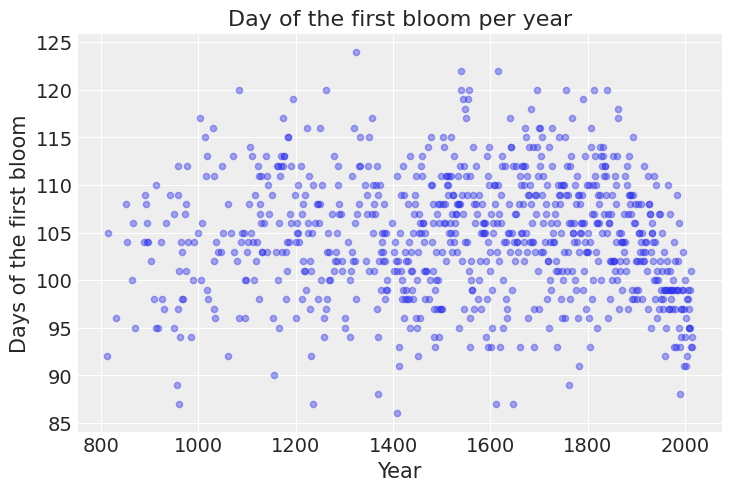

In [6]:
plot_scatter(data);

Here we can observe the day of the first bloom ranges between 85 and 125 approximately, which correspond to late March and early May respectively. On average, the first bloom occurs on the 105th day of the year, which is middle April.

## Determine knots

The spline will have 15 knots, which split the range of the `"year"` variable into 16 contiguous sections. These knots are the boundaries of the basis functions. These basis functions make up a piecewise continuous polynomial, and so they are enforced to meet at the knots. We use the default degree for each piecewise polynomial, which is 3, and is known as **cubic spline**.

The knots are distributed unevenly over the range of `"year"` in such a way there is a similar proportion of values between each section.

In [7]:
num_knots = 15
knots = np.quantile(data.year, np.linspace(0, 1, num_knots))

In [8]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

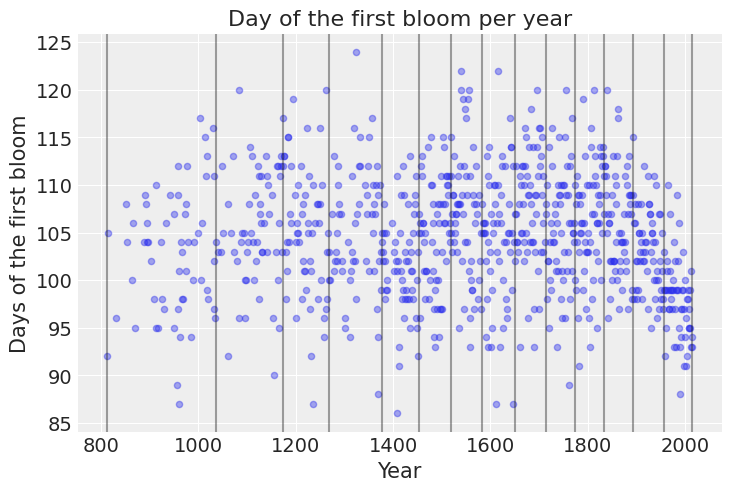

In [9]:
ax = plot_scatter(data)
plot_knots(knots, ax);

## The model

$$
\begin{aligned}
Y_i & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \sum_{k=1}^K{w_kB_{k, i}} \\
\end{aligned}
$$


The second line tells that for eac observation $i$, the mean is influenced by all the basis functions (going from $k=1$ to $k=K$)

And the priors are 

$$
\begin{aligned}
\alpha & \sim \text{Normal}(100, 10) \\
w_j & \sim \text{Normal}(0, 10)\\
\sigma & \sim \text{Exponential(1)}
\end{aligned}
$$

where $j = 1, \cdots, 15$


In [10]:
# We only pass the internal knots to the `bs()` function.
iknots = knots[1:-1]

priors = {
    "common": bmb.Prior("Normal", mu=0, sigma=10), 
    "Intercept": bmb.Prior("Normal", mu=100, sigma=10),
    "sigma": bmb.Prior("Exponential", lam=1)
}

model = bmb.Model("doy ~ bs(year, knots=iknots, intercept=True)", data, priors=priors)
model

Formula: doy ~ bs(year, knots=iknots, intercept=True)
Family name: Gaussian
Link: identity
Observations: 827
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 100, sigma: 10)
    bs(year, knots = iknots, intercept = True) ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)


In [11]:
def plot_spline_basis(basis, year):
    df = (
        pd.DataFrame(basis)
        .assign(year=year)
        .melt("year", var_name="basis_idx", value_name="value")
    )

    _, ax = plt.subplots()

    for idx in df.basis_idx.unique():
        d = df[df.basis_idx == idx]
        ax.plot(d["year"], d["value"])
    
    return ax

<!-- The b-spline basis is plotted below, showing the "domain" of each piece of the spline.  The height of each curve indicates how "influential" the corresponding model covariate (one per spline region) will be on model's "inference" of that region.  (The quotes are to indicate that these words were chosen to help with interpretation and are not the proper mathematical terms.)  The overlapping regions represent the knots, showing how the smooth transition from one region to the next is formed. -->

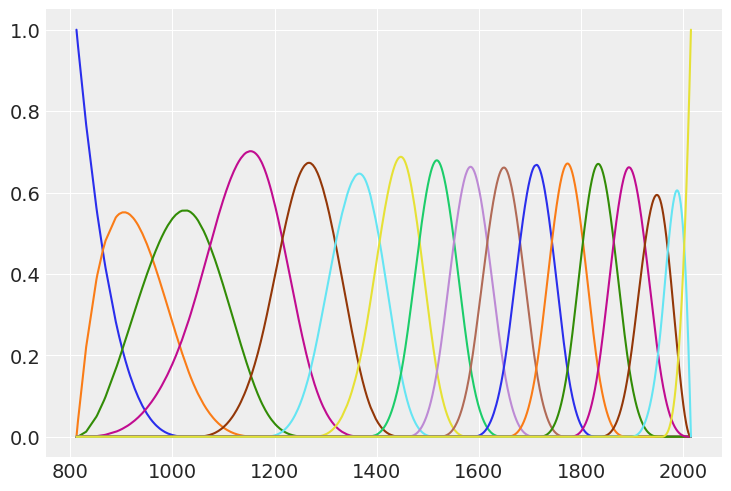

In [12]:
B = model._design.common["bs(year, knots = iknots, intercept = True)"]
plot_spline_basis(B, data["year"].values);


## Fit model

In [13]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [doy_sigma, bs(year, knots = iknots, intercept = True), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,103.664,2.461,99.062,108.353,0.116,0.082,446.0,658.0,1.0
"bs(year, knots = iknots, intercept = True)[0]",-3.337,3.911,-11.051,3.583,0.129,0.091,924.0,1546.0,1.0
"bs(year, knots = iknots, intercept = True)[1]",-1.045,3.964,-8.592,6.007,0.136,0.096,855.0,1165.0,1.0
"bs(year, knots = iknots, intercept = True)[2]",-1.452,3.587,-8.202,5.188,0.128,0.090,785.0,1202.0,1.0
"bs(year, knots = iknots, intercept = True)[3]",4.548,2.971,-1.128,9.967,0.122,0.089,594.0,824.0,1.0
"bs(year, knots = iknots, intercept = True)[4]",-1.181,2.979,-6.645,4.610,0.126,0.089,563.0,856.0,1.0
"bs(year, knots = iknots, intercept = True)[5]",4.013,2.951,-1.685,9.324,0.118,0.083,631.0,799.0,1.0
"bs(year, knots = iknots, intercept = True)[6]",-5.635,2.908,-11.238,-0.320,0.124,0.088,549.0,945.0,1.0
"bs(year, knots = iknots, intercept = True)[7]",7.450,2.863,1.508,12.220,0.120,0.085,573.0,808.0,1.0
"bs(year, knots = iknots, intercept = True)[8]",-1.223,2.933,-7.197,4.133,0.121,0.086,586.0,1055.0,1.0


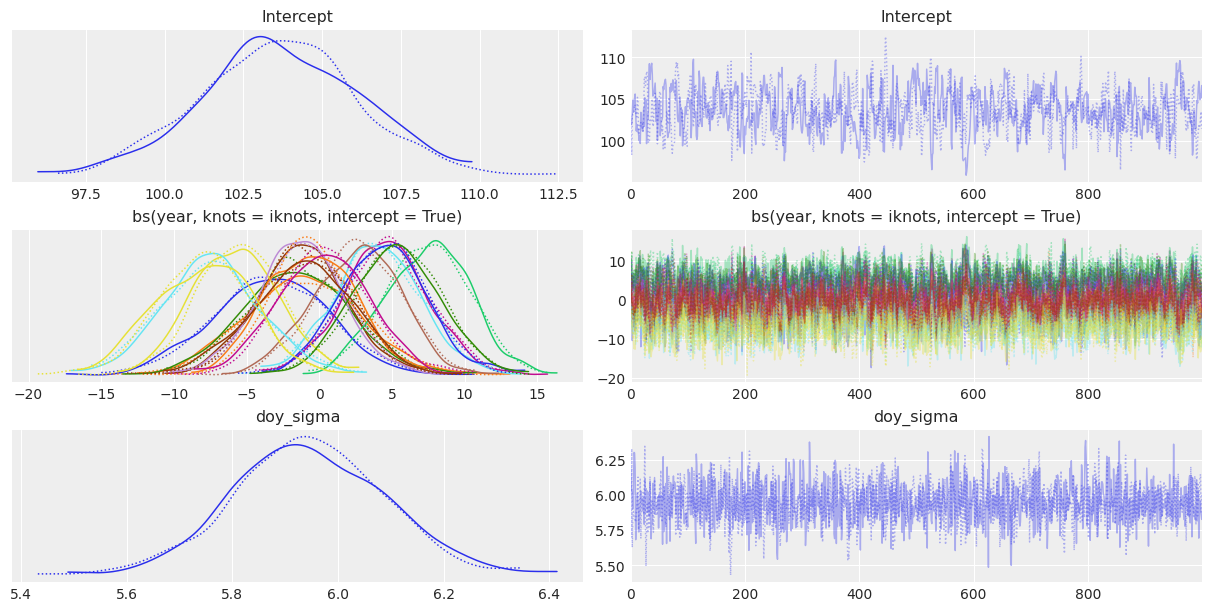

In [15]:
az.plot_trace(idata);

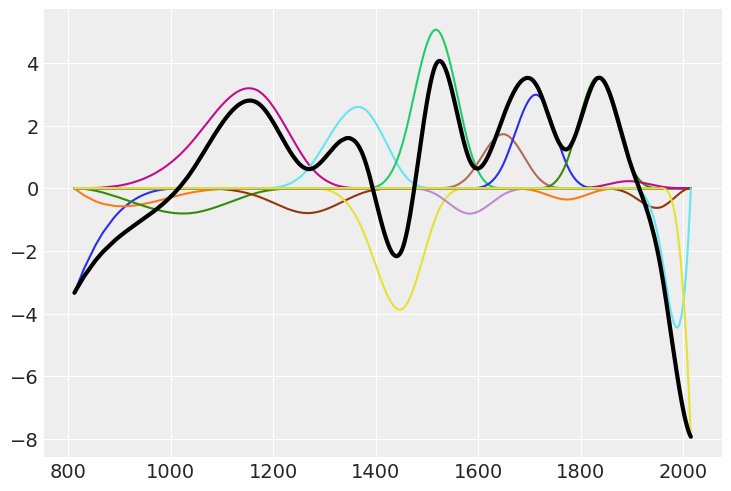

In [16]:
wp = idata.posterior["bs(year, knots = iknots, intercept = True)"].values.mean(axis=(0, 1))

ax = plot_spline_basis(B * wp.T, data["year"].values)
ax.plot(data.year.values, np.dot(B, wp.T), color="black", lw=3);

## Plot predictions and credible bands

In [17]:
new_data = pd.DataFrame({"year": np.linspace(data.year.min(), data.year.max(), num=500)})
model.predict(idata, data=new_data)

y_hat = idata.posterior["doy_mean"].values
y_hat_mean = y_hat.mean((0, 1))
hdi_data = np.quantile(y_hat, [0.03, 0.94], axis=(0, 1))

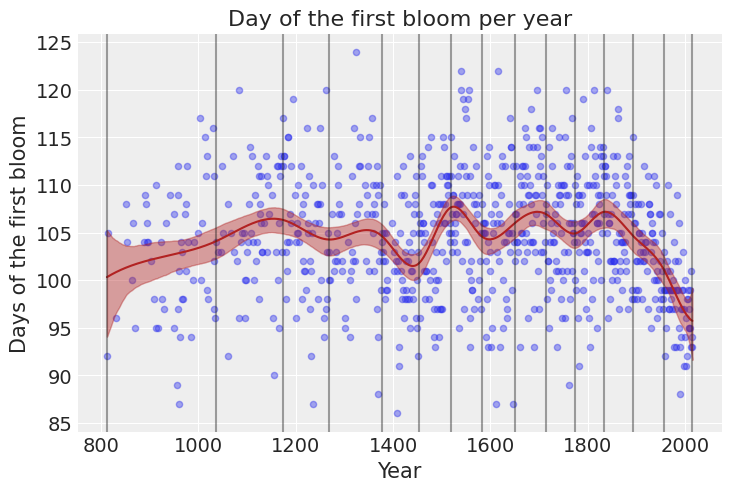

In [18]:
ax = plot_scatter(data)
ax.plot(new_data["year"], y_hat_mean, color="firebrick")
ax.fill_between(new_data["year"], hdi_data[0], hdi_data[1], alpha=0.4, color="firebrick")
plot_knots(knots, ax);

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Oct 15 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

bambi     : 0.6.3
arviz     : 0.11.2
sys       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
numpy     : 1.20.3
pandas    : 1.3.2
matplotlib: 3.4.3

Watermark: 2.1.0

